# **Chapter 2: Digital image fundamentals**

In this notebook we set up a simple pipeline for turning continuous functions into digital form, and then examine how resampling and interpolation affect the result. The goal is to build intuition for sampling, quantization, and geometric transforms before we move on to more advanced processing.

First, we import the necessary libraries (NumPy and Matplotlib), and set up grayscale display preferences.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.cmap']='gray'

## Image sampling
We start by sampling a synthetic function on a grid and then quantize it: first normalize to $[0,1]$, convert to 8 bits, and wrap the steps into a helper function `sample_and_quantize`. We then vary the spatial domain to show how too-wide a field with a fixed pixel count produces aliasing, and visualize the result both as an image and as a 3D surface.

Let us consider the 2D function $f(x,y) = \cos(x^2+y^2)$ where $x,y \in [-\pi,\pi]$. We sample and quantize it to a digital 8-bit image that has the size of $512 \times 512$ pixels.

In [2]:
N=512

In [3]:
t=np.linspace(-np.pi,np.pi,N)

In [4]:
t.shape

(512,)

In [5]:
x, y = np.meshgrid(t,t)

In [6]:
x.shape

(512, 512)

In [7]:
f = np.cos(x**2+y**2)

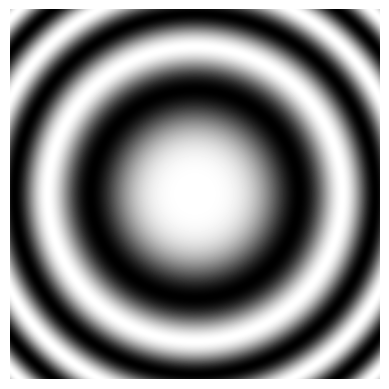

In [8]:
plt.imshow(f)
plt.axis('off');

The image obtained is still "analog", and next, we need to quantize it to 8 bits. Before quantization, we normalize its values to \[0, 1 \].

In [9]:
f.min(),f.max()

(-0.9999999917630279, 0.9999999995524146)

In [10]:
g = (f-f.min())/(f.max()-f.min())

In [11]:
g.min(),g.max()

(0.0, 1.0)

In [12]:
g.dtype

dtype('float64')

The quantization can be done with the following function from `scikit-image`.

In [13]:
from skimage import img_as_ubyte

In [14]:
I = img_as_ubyte(g)

In [15]:
I.dtype

dtype('uint8')

In [16]:
I.min(),I.max()

(0, 255)

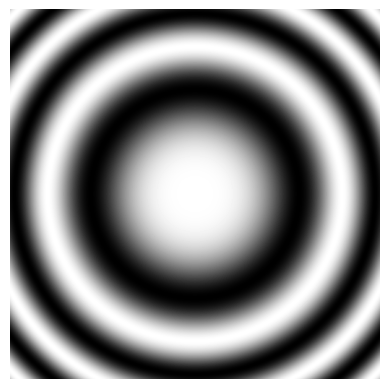

In [17]:
plt.imshow(I)
plt.axis('off');

There is no visible difference to the unquantized version.

To make this process a bit more handy and general, we combine the previous steps to a single function. 

In [18]:
def sample_and_quantize(f,number_of_pixels,half):
    t = np.linspace(-half,half,number_of_pixels)
    x, y = np.meshgrid(t,t)
    value = f(x, y)
    normalized = (value-value.min())/(value.max()-value.min())
    return img_as_ubyte(normalized)

Our image function is represented as a lambda function.

In [19]:
fun = lambda x, y: np.cos(x**2+y**2)

Let's try this with the range $x,y \in [-20,20]$.

In [20]:
I2 = sample_and_quantize(fun,512,20)

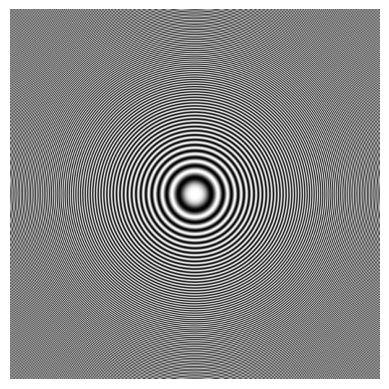

In [21]:
plt.imshow(I2)
plt.axis('off');

Now, we observe that the digital image obtained has some weird patterns. This is called aliasing, and it will be discussed more in Chapter 4.

We can also conveniently visualize the images as 3D graphs.

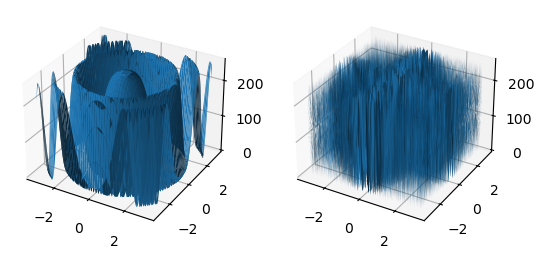

In [22]:
fig=plt.figure()
ax=fig.add_subplot(1,2,1,projection='3d')
ax.plot_surface(x,y,I)
ax=fig.add_subplot(1,2,2,projection='3d')
ax.plot_surface(x,y,I2)

## Geometric transformations and interpolation

Next, we apply an affine transform (scale $1.5\times$, rotation $30^\circ$, translation $(250,0)$) to the `skimage.data.chelsea()` first with nearest neighbor interpolation. We expand the image size to avoid cropping, then compare boundary quality with bilinear and bicubic interpolation, finally plotting the absolute difference between bilinear and bicubic to illustrate how interpolation choice changes fine detail.

In [23]:
from skimage import data

In [24]:
I = data.chelsea()

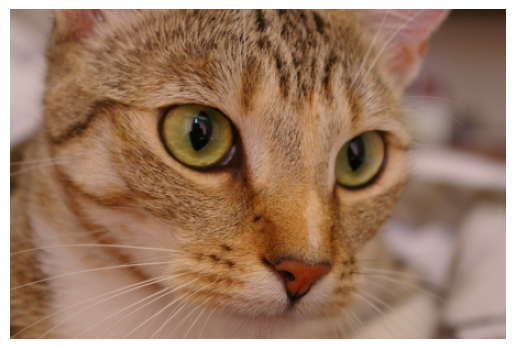

In [25]:
plt.imshow(I)
plt.axis('off');

We can use the module `transform` from `scikit-image`, which includes a function `AffineTransform` to define an arbitrary affine transformation. The scaling, rotation and translation parameter are given as function parameters.

In [26]:
from skimage.transform import AffineTransform, warp

In [27]:
A = AffineTransform(scale=(1.5,1.5),rotation=30/180*np.pi,translation=(250,0))

This is the affine transformation matrix what we obtain.

In [28]:
print(A.params)

[[  1.29903811  -0.75       250.        ]
 [  0.75         1.29903811   0.        ]
 [  0.           0.           1.        ]]


Then, we perform the actual image transformation using the `warp` function. Notice that the affine transformation matrix is given as its inverse to the function. The `order` parameter determines the interpolation scheme. The value 0 means **nearest neighbor interpolation**.

In [29]:
B = warp(I,A.inverse,order=0)

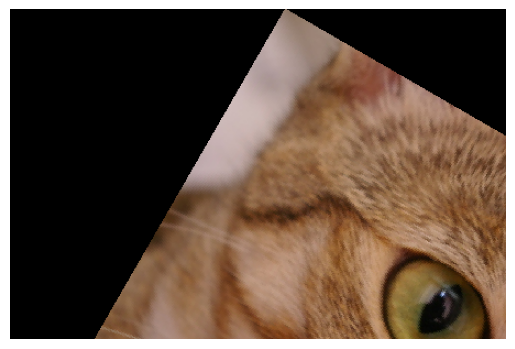

In [30]:
plt.imshow(B)
plt.axis('off');

We obviously need to increase image size to make the output fit to the result.

In [31]:
B = warp(I,A.inverse,order=0,output_shape=(800,1000))

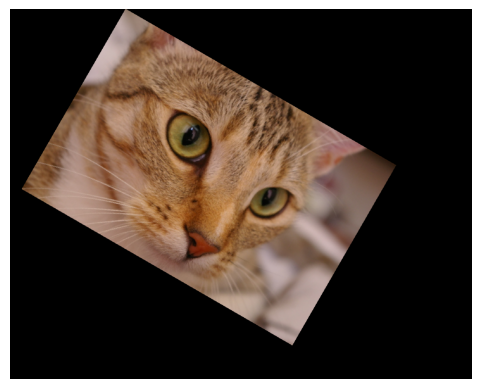

In [32]:
plt.imshow(B)
plt.axis('off');

Zooming to the boundary shows the staircase effect that is characteristic to the nearest neighbor interpolation.

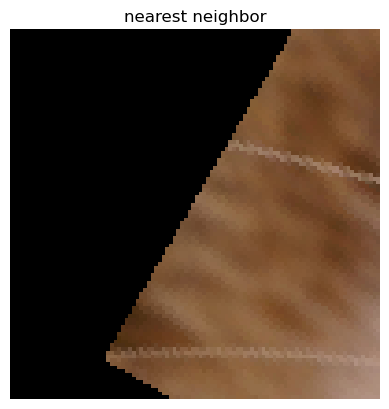

In [33]:
plt.imshow(B[300:400,0:100])
plt.title('nearest neighbor')
plt.axis('off');

To use **bilinear interpolation**, we change the parameter value to 1.

In [34]:
C = warp(I,A.inverse,order=1,output_shape=(800,1000))

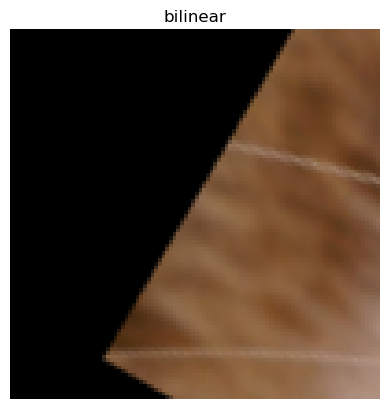

In [35]:
plt.imshow(C[300:400,0:100])
plt.title('bilinear')
plt.axis('off');

The parameter value 3 means **bicubic interpolation**.

In [36]:
D = warp(I,A.inverse,order=3,output_shape=(800,1000))

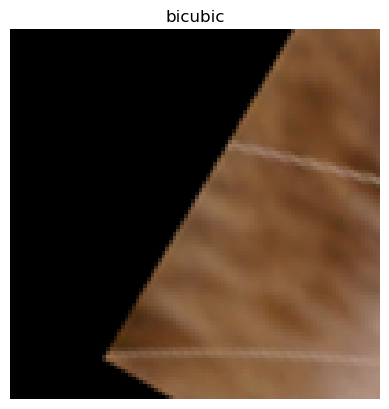

In [37]:
plt.imshow(D[300:400,0:100])
plt.title('bicubic')
plt.axis('off');

Finally, we can visualize the absolute difference between bilinear and bicubic interpolation. Because `warp`changes the data type to float, we don't need to make the conversion separately.

In [38]:
D.dtype

dtype('float64')

In [39]:
E = abs(C-D)

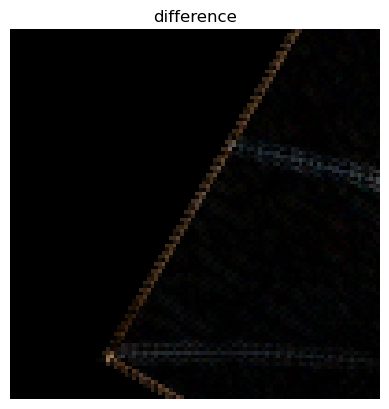

In [40]:
plt.imshow(E[300:400,0:100]*10)
plt.title('difference')
plt.axis('off');